Import Libraries

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, ReLU, UpSampling2D
from keras.preprocessing import image

from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import confusion_matrix
import seaborn as sns

Function to equalize the histogram of an image

In [6]:
# Histogram Equalization
def histogram_equalization(img):
    # Convert the image to HSV (Hue, Saturation, Value)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Apply histogram equalization to the V (Value) channel (intensity)
    hsv_img[..., 2] = cv2.equalizeHist(hsv_img[..., 2])

    # Convert back to BGR color space
    eq_color_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)

    return eq_color_img

Function to perform gamma transformation

In [7]:
#Gamma Transformation
def gamma_correction(img, gamma):
    table = np.array([((i / 255.0) ** gamma) * 255 for i in range(256)]).astype("uint8")
    gamma_corrected = cv2.LUT(img, table)
    return gamma_corrected

Function to increase contrast of an image

In [56]:
def increase_contrast(img, factor=5):
    # Convert the image to float32 to avoid clipping
    img_float = img.astype(np.float32)

    # Increase the contrast by multiplying the pixel values by a factor
    img_float = img_float * factor

    # Clip the values to be within the valid range [0, 255]
    img_float = np.clip(img_float, 0, 255)

    # Convert back to uint8
    contrast_img = img_float.astype(np.uint8)

    return contrast_img

Load a particular image from LOL dataset and perform the above transformations.

In [57]:
# Load your low-light image
good_img = cv2.imread('goodImage.png')  # Replace with the path to your image
ori_img = cv2.imread('lowLightImage.png')  # Replace with the path to your image

# #image with high conrast
high_contrast_img = increase_contrast(ori_img)

# Apply Histogram Equalization
hist_eq_img = histogram_equalization(ori_img)

# Apply Gamma Correction
gamma_img = gamma_correction(ori_img, gamma=0.3)

enhanced_images = [hist_eq_img, gamma_img, high_contrast_img]
enhanced_images_labels = ["Histogram Equalized", "Gamma Transformed (0.3)", "High Contrast Image"]

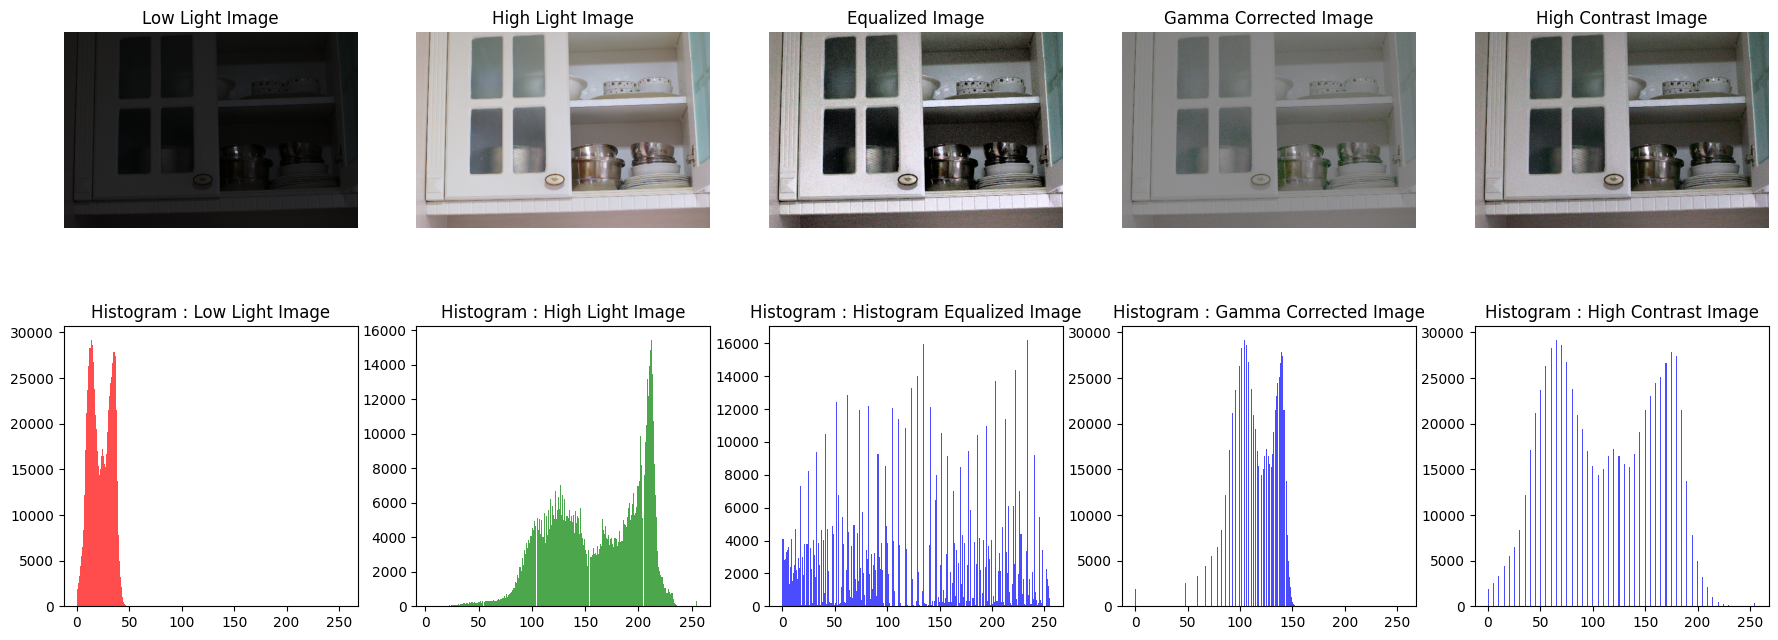

In [58]:
# Show the results with histograms
fig, axes = plt.subplots(2, 5, figsize=(22, 8))

# Images
axes[0, 0].imshow(cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Low Light Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(cv2.cvtColor(good_img, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title('High Light Image')
axes[0, 1].axis('off')

axes[0, 2].imshow(cv2.cvtColor(hist_eq_img, cv2.COLOR_BGR2RGB))
axes[0, 2].set_title('Equalized Image')
axes[0, 2].axis('off')

axes[0, 3].imshow(cv2.cvtColor(gamma_img, cv2.COLOR_BGR2RGB))
axes[0, 3].set_title('Gamma Corrected Image')
axes[0, 3].axis('off')

axes[0, 4].imshow(cv2.cvtColor(high_contrast_img, cv2.COLOR_BGR2RGB))
axes[0, 4].set_title('High Contrast Image')
axes[0, 4].axis('off')

# Histograms
axes[1, 0].hist(ori_img.ravel(), bins=256, color='red', alpha=0.7)
axes[1, 0].set_title('Histogram : Low Light Image')

axes[1, 1].hist(good_img.ravel(), bins=256, color='green', alpha=0.7)
axes[1, 1].set_title('Histogram : High Light Image')

axes[1, 2].hist(hist_eq_img.ravel(), bins=256, color='blue', alpha=0.7)
axes[1, 2].set_title('Histogram : Histogram Equalized Image')

axes[1, 3].hist(gamma_img.ravel(), bins=256, color='blue', alpha=0.7)
axes[1, 3].set_title('Histogram : Gamma Corrected Image')

axes[1, 4].hist(high_contrast_img.ravel(), bins=256, color='blue', alpha=0.7)
axes[1, 4].set_title('Histogram : High Contrast Image')
plt.show()

# Performance Evaluation Techniques

MSE : Mean Square Error </br>
Calculating the MSE of the High light image wuth the enhanced image

In [38]:
def calculate_mse(ref,img):
  """
    Calculate the Mean Squared Error (MSE) between two images.

    Parameters:
        ref: The first image as a NumPy array.
        img: The second image as a NumPy array.

    Returns:
        mse: The mean squared error between the two images.
    """
  mse = np.mean((ref - img) ** 2)
  return mse

PSNR : Peak Signal to Noise Ratio

In [34]:
# Function to compute PSNR
def calculate_psnr(ref, img):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) between two images.

    Parameters:
        ref: The first image as a NumPy array.
        img: The second image as a NumPy array.

    Returns:
        psnr: The PSNR value in decibels (dB).
    """
    mse = np.mean((ref - img) ** 2)
    if mse == 0:
        return 100  # Perfect match
    max_pixel = 255.0
    return 20 * np.log10((max_pixel ** 2) / np.sqrt(mse))

SSIM : structural similarity index measure

In [35]:
# Function to compute SSIM
def calculate_ssim(ref, img):
    """
    Calculate the Structural Similarity Index (SSIM) between two images.

    Parameters:
        ref: The first image as a NumPy array.
        img: The second image as a NumPy array.

    Returns:
        ssim_value: The SSIM value (ranges from -1 to 1).
    """
    ref_gray = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return ssim(ref_gray, img_gray)

Analyse the abouve paramters of obtained images

In [83]:
import pandas as pd

results = []
for i in range(3):
  mse_value = calculate_mse(good_img, enhanced_images[i])
  psnr_value = calculate_psnr(good_img, enhanced_images[i])
  ssim_value = calculate_ssim(good_img, enhanced_images[i])
  results.append({
            "Image": enhanced_images_labels[i],
            "MSE": mse_value,
            "PSNR (dB)": psnr_value,
            "SSIM": ssim_value
        })

# Convert results to a DataFrame
df = pd.DataFrame(results)


In [62]:
def plot_heatmap(df, metric, title):
    """
    Plot a heatmap for the given metric.

    Parameters:
        df: DataFrame containing the image analysis results.
        metric: The metric to plot ('MSE', 'PSNR (dB)', or 'SSIM').
        title: Title for the heatmap.
    """
    # Prepare the heatmap data
    heatmap_data = pd.DataFrame({
        "Image": df["Image"],
        metric: df[metric]
    }).set_index("Image")

    # Create the heatmap
    plt.figure(figsize=(5, 3))
    sns.heatmap(heatmap_data.T, annot=True, fmt=".2f", cmap="Blues", cbar_kws={"label": metric})
    plt.title(title)
    plt.ylabel("")
    plt.xlabel("Images")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

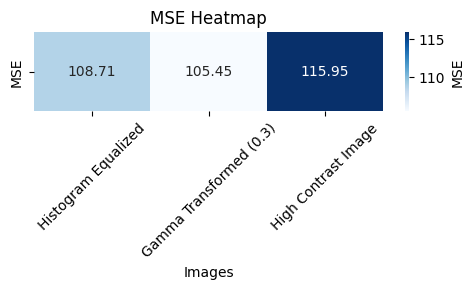

In [64]:
 # Plot heatmaps for each metric
plot_heatmap(df, "MSE", "MSE Heatmap")

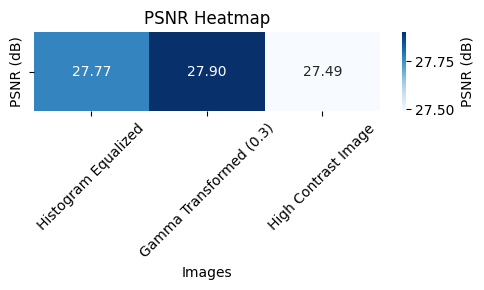

In [65]:
plot_heatmap(df, "PSNR (dB)", "PSNR Heatmap")

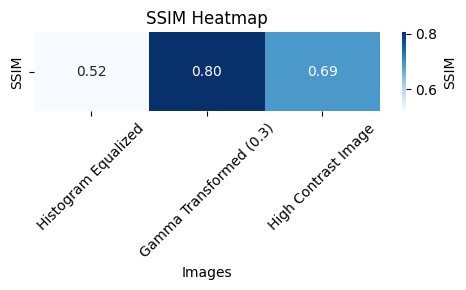

In [66]:
plot_heatmap(df, "SSIM", "SSIM Heatmap")

In [84]:
print(df)

                     Image         MSE  PSNR (dB)      SSIM
0      Histogram Equalized  108.709669  27.768122  0.520332
1  Gamma Transformed (0.3)  105.449785  27.900347  0.804377
2      High Contrast Image  115.952628  27.487998  0.689098


By comparing the values Gamma transformed image is the closest to the actual high light image. (Lowest MSE and Highest PSNR , SSIM)

# Classify based on SSIM and PSNR thresholds

We defined an output image as accurate if the PSNR >30 and SSIM>0.85

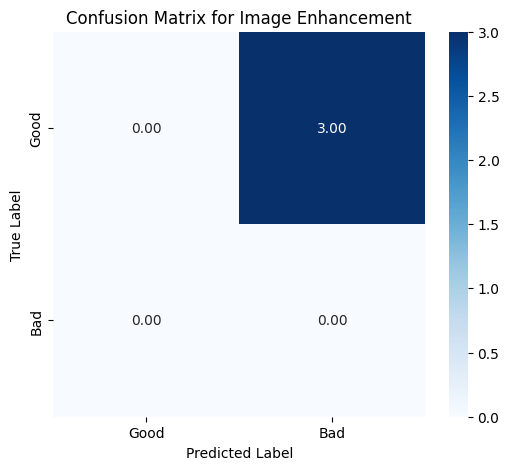

In [82]:
# Classify based on SSIM and PSNR thresholds
def classify_image(ref, img):
    ssim_score = calculate_ssim(ref, img)
    psnr_score = calculate_psnr(ref, img)
    if ssim_score > 0.85 and psnr_score > 30:
        return "Good"
    else:
        return "Bad"

# Generate labels
true_labels = ["Good", "Good", "Good"]
pred_labels = [
    classify_image(good_img, hist_eq_img),
    classify_image(good_img, gamma_img),
    classify_image(good_img, high_contrast_img)
]

# Compute confusion matrix
labels = ["Good", "Bad"]
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Image Enhancement")
plt.show()


# Classify the images pixels based on pixel intensity level differences


The acceptable difference between the intensities of ground truth and enhanced image is taken as 10 (level of intensity)


* True Positive (TP): Enhanced pixels that
match the reference and were improved correctly. </br>
* False Positive (FP): Enhanced pixels that were over-enhanced beyond the acceptable range. </br>
* True Negative (TN): Pixels that didn't need enhancement and were left unchanged. </br>
* False Negative (FN): Pixels that were under-enhanced or not improved when they should have been. </br>

This is a quantitative analysis in pixel level, which is more fine graded compared to global metrices like PSNR, SSIM

In [79]:
def calculate_confusion_matrix(ground_truth, enhanced, threshold=10):
    """
    Calculate the confusion matrix for an enhanced image compared to the ground truth image.

    Args:
        ground_truth (np.array): The "good image" (reference image) in BGR format.
        enhanced (np.array): The enhanced image in BGR format.
        threshold (int): The tolerance for pixel intensity differences.

    Returns:
        dict: Confusion matrix containing TP, FP, TN, FN counts.
    """

    # Convert images to grayscale for intensity comparison
    ground_truth_gray = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)
    enhanced_gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)

    # Initialize confusion matrix components
    TP = FP = TN = FN = 0

    # Compare pixel intensities
    for gt_pixel, en_pixel in zip(ground_truth_gray.flatten(), enhanced_gray.flatten()):
        diff = abs(gt_pixel - en_pixel)
        if diff <= threshold:  # Within acceptable range, considered a match
            if en_pixel == gt_pixel:  # No enhancement needed
                TN += 1
            else:  # Enhanced correctly
                TP += 1
        else:
            if en_pixel > gt_pixel:  # Over-enhanced
                FP += 1
            else:  # Under-enhanced
                FN += 1

    # Create the confusion matrix
    confusion_matrix = {
        "True Positive": TP,
        "False Positive": FP,
        "True Negative": TN,
        "False Negative": FN
    }

    return confusion_matrix

def display_confusion_matrix_as_table(conf_matrix, title):
    """
    Display the confusion matrix as a table using pandas DataFrame.

    Args:
        conf_matrix (dict): Confusion matrix as a dictionary.
        title (str): Title of the table.
    """
    # Convert dictionary to DataFrame
    df = pd.DataFrame([conf_matrix])

    # Display the table
    print(f"\n{title}")
    display(df)

    # Plot a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(df, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.show()


In [80]:
# Calculate confusion matrices
hist_eq_conf_matrix = calculate_confusion_matrix(good_img, hist_eq_img)
gamma_conf_matrix = calculate_confusion_matrix(good_img, gamma_img)
contrast_conf_matrix = calculate_confusion_matrix(good_img, high_contrast_img)

<ipython-input-79-0c1c247b0a94>:23: RuntimeWarning: overflow encountered in scalar subtract
  diff = abs(gt_pixel - en_pixel)



Confusion Matrix: Histogram Equalization


,True Positive,False Positive,True Negative,False Negative
0,13852,39982,1341,184825


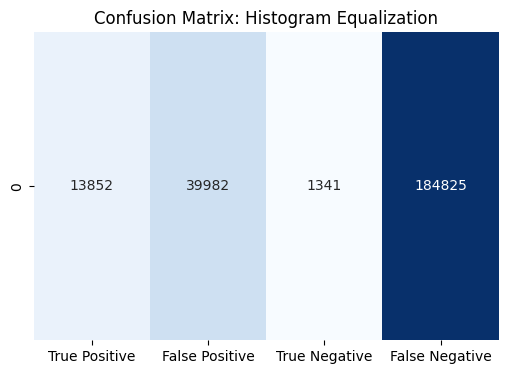


Confusion Matrix: Gamma Correction


,True Positive,False Positive,True Negative,False Negative
0,20797,4518,856,213829


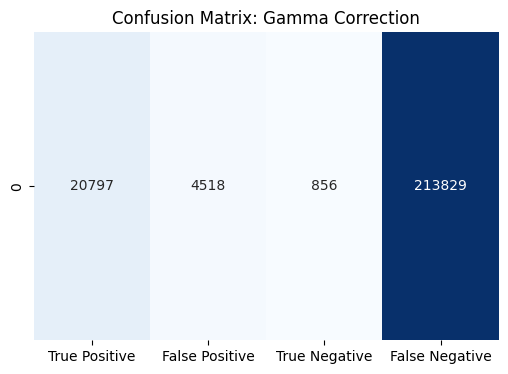


Confusion Matrix: Contrast Enhancement


,True Positive,False Positive,True Negative,False Negative
0,169,48,95,239688


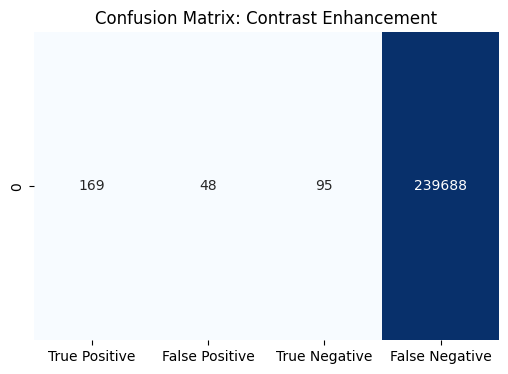

In [81]:
# Display confusion matrices as tables
display_confusion_matrix_as_table(hist_eq_conf_matrix, "Confusion Matrix: Histogram Equalization")
display_confusion_matrix_as_table(gamma_conf_matrix, "Confusion Matrix: Gamma Correction")
display_confusion_matrix_as_table(contrast_conf_matrix, "Confusion Matrix: Contrast Enhancement")